In [52]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# # p et q sont deux listes de vecteru de taille n représentant les probas conditionelles
#     # ATTENTION en sortie du réseau de neurones, on a un vecteur de taille n
#     # en effet, on  a besoin des probas conditionelles pour chaque i. Donc, on ne peut pas demander au réseau de 
#     # sortir direct la proba q_theta(s)
#     # Donc, c'est dans la fonction loss qu'on va convertir ces probas conditionelles en proba d'observer s (par une simple multiplication)
#     probasp=[]
#     probasq=[]
#     for pi in p:
#         res=1
#         for i in pi:
#             res*=i
#         probasp.append(res)
#     for qi in q:
#         res=1
#         for i in qi:
#             res*=i
#         probasq.append(res)

In [118]:
def Kulback_Leibler(q,p): # p et q sont des listes de probas d'observation des mêmes s
    for i in range(len(p)):
        if p[i] == 0:
            p[i] = 1e-10
    result = 0 
    for i in range(len(p)):
        result += q[i]*np.log(q[i]/p[i])
    return result

In [120]:
a=torch.tensor([0.1,0.2,0.3,0.4])
b=torch.tensor([0.25,0.25,0.25,0.25])
Kulback_Leibler(b,b)

tensor(0.)

In [6]:


def train(models, q , p_0,   n_iter=100, lr=1e-2):
    nombre_de_neurones=len(models)
    optimizers=[torch.optim.Adam(models[i].parameters(), lr=lr) for i in range(nombre_de_neurones)]
    p=p_0
    for epoch in range(n_iter):
        p='...'# à compléter
        for i in range(nombre_de_neurones):
            optimizers[i].zero_grad()
            loss=Kulback_Leibler(p, q)
            loss.backward()
            optimizers[i]
           


In [ ]:

def train(model, n_iter=100, lr=1e-2):
    plt.figure(figsize=(20, 8))
    axs = [plt.subplot(2, 5, i) for i in range(1, 11)]
    losses = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # What is Adam? Which other simpler optimizers can you use?

    for epoch in range(n_iter):
        optimizer.zero_grad() # What is this step? IMPORTANT LINE
        loss = loss_fn(model(x_train), y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
       
        if epoch % (n_iter/10) == 0:
            print(f'Epoch {epoch}: {loss.item()}')

            # plot progress
            ax_index = int(epoch // (n_iter/10))
            plt.sca(axs[ax_index])
            plt.plot(x_grid, target(x_grid), label='target')
            plt.plot(x_grid, grab(model(x_grid)).squeeze(), label='model init')
            
    return losses




def loss_fn(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)

In [39]:
n=4
M = torch.zeros((n, n), dtype=torch.int)  # Crée une matrice de zéros de taille n x n
        
for i in range(n):
    for j in range(i, n):
        M[i][j] = 0

# Remplit la partie inférieure de la diagonale avec des uns
for i in range(1, n):
        for j in range(i):
                M[i][j] = 1

In [44]:
A=torch.tensor([[1, 2], [3, 4]])

In [48]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, mask, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.mask = mask

    def forward(self, input):
        return nn.functional.linear(input, self.weight * self.mask, self.bias)

In [54]:
torch.sigmoid(torch.tensor([0.0, 2.0]))

tensor([0.5000, 0.8808])

In [50]:
class VAN(nn.Module):
    def __init__(self, input_size, activation=torch.sigmoid):
        super(VAN, self).__init__() #initialisation obligatoire
        self.input_size = input_size

        # Création de la matrice de masque : que des 0 sur et au dessus de la diagonale et que des 1 dessous
        M = torch.zeros((input_size, input_size), dtype=torch.int)
        for i in range(input_size):
            for j in range(i, input_size):
                M[i][j] = 0
        for i in range(1, input_size):
            for j in range(i):
                M[i][j] = 1

        self.fc1 = MaskedLinear(input_size, input_size, mask=M)
        self.activation = activation

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        # à cette ligne on a multiplié x par la matrice de masque (triangulaire inférieure), puis appliqué la fonction d'activation
        # donc la première coordonnée de x vaut activation(0) (normal, s^_1 ne dépend de personne)
        # il faut donc ajouter 0.5 à la première coordonnée pour montrer qu'elle vaut 0 et 1 avec proba 0.5
        x[0] = 0.5
        return x


In [113]:
train_set=torch.zeros((5, 2))
# 5 points de taille 2
print(train_set)
train_set[0][0]=torch.bernoulli(torch.tensor(0.5))
print(train_set)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
tensor([[1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


In [114]:
torch.tensor([1, 2, 3, 4, 5])

tensor([1, 2, 3, 4, 5])

In [ ]:
def train(model, p_obj,  n_iter=100, lr=1e-2, train_size=100):

    losses = []

    # p_obj est la distribution à approximer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    # il faut tirer un train_set grâce au modèle pour s'entraîner dessus
    train_set=torch.zeros((train_size, model.input_size))
    for i in range(train_size):
        # pour tirer un x dans x_train, on tire une bernoulli de paramètre 0.5 : c'est s_1
        # comment avoir s_2 ? ON fait passer le vecteur [s_1, 0, 0, 0] dans le réseau de neurones
        # en sortie du réseau de neurones, on a y =[ s1 randomn, p(s2|s1), p(s3|s1), p(s4|s1)...]
        # la deuxième coordonnée de y est p(s2|s1), donc on tire une bernoulli de paramètre p(s2|s1)
        # puis on recommence !
        # on fait ça train_size fois
        train_set[i][0]=torch.bernoulli(torch.tensor(0.5))
        for j in range(1, model.input_size):
            y_pred=model(train_set[i])
            p_j= y_pred[j] # c'est p(s_j|s_{i<j})
            train_set[i][j]=torch.bernoulli(torch.tensor(p_j)) # on tire une bernoulli de paramètre p(s_j|s_{i<j}) pour la j-ème variable
    
    y_train=torch.tensor([p_obj(s) for s in train_set])
    # à cette étape, on a un train set, on peut entraîner le modèle
    for epoch in range(n_iter):
        optimizer.zero_grad() # What is this step? IMPORTANT LINE
        listes_de_probas_conditionelles=model(train_set) # on récupère les probas conditionelles, il faut les multiplier pour avoir les probas tout court
        q_theta_predit=[]
        for proba_conditionelle in listes_de_probas_conditionelles:
            res=1
            for i in proba_conditionelle:
                res*=i
            q_theta_predit.append(res)
        # c'est bon on a les probas, on peut appliquer DKL
        loss = Kulback_Leibler(torch.tensor(q_theta_predit), y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % (n_iter/10) == 0:
            print(f'Epoch {epoch}: {loss.item()}')
    return losses

            
            


In [81]:
torch.sigmoid(torch.tensor([0.5, 2.0]))


tensor([0.6225, 0.8808])

In [49]:
n=7
M = torch.zeros((n, n), dtype=torch.int)  # Crée une matrice de zéros de taille n x n

for i in range(n):
    for j in range(i, n):
        M[i][j] = 0

# Remplit la partie inférieure de la diagonale avec des uns
for i in range(1, n):
        for j in range(i):
                M[i][j] = 1


In [ ]:

class MLP(nn.Module):
    """
    a MLP class inheriting from the parent class nn.Module. 
    nn.Module is the generic parent class of models in Pytorch.
    It requires a method called forward. 
    
    Pytorch will be able to recursively recover all parameters of the
    attributes of a nn.Module object provided the attributes have themselves
    type nn.Modules or nn.ModuleList.

    In this implementation we explicitly specify the scale of initialization 
    of the weight matrices.
    """
    def __init__(self, layerdims, activation=torch.relu, out_activation=None, init_scale=1):
        super(MLP, self).__init__()

        self.layerdims = layerdims
        self.activation = activation
        self.out_activation = out_activation

        linears = [
            nn.Linear(layerdims[i], layerdims[i + 1]) for i in range(len(layerdims) - 1)
        ]

        if init_scale is not None:
            for l, layer in enumerate(linears):
                torch.nn.init.normal_(
                    layer.weight, std=init_scale / np.sqrt(layerdims[l])
                )
                torch.nn.init.zeros_(layer.bias)

        self.linears = nn.ModuleList(linears)

    def forward(self, x):
        layers = list(enumerate(self.linears))
        for _, l in layers[:-1]:
            x = self.activation(l(x))
        y = layers[-1][1](x)
        if self.out_activation is not None:
            y = self.out_activation(y)
        return y



In [126]:
False in torch.tensor([1, 2, 3, 4, 5])==torch.tensor([1, 2, 3, 4, 5])

False

ValueError: only one element tensors can be converted to Python scalars

In [11]:
torch.eq(torch.tensor([1, 2, 3, 4, 5]), torch.tensor([1, 2, 3, 4, 5])).all().item()

True

In [9]:
p= torch.tensor([0.1, 0.2, 0.3, 0.4])
q= torch.tensor([0.25, 0.25, 0.25, 0.25])
Kulback_Leibler(p, p)



tensor(0.)

In [6]:
from VAN import *
import matplotlib.pyplot as plt
taille=6
def p(s):
    if torch.eq(s, torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 0.0])).all().item():
        return 0.5
    elif torch.eq(s, torch.tensor([0.0, 0.0, 0.0, 1.0, 1.0, 1.0])).all().item():
        return 0.5
    else:
        return 0.00001
    
def p2(s):
    return 1/(2**6)

mymodel=VAN(taille, torch.sigmoid)

l=train(mymodel, p, n_iter=100, lr=1e-2, train_size=100)

Epoch 0: 686.890869140625
Epoch 10: 593.0250854492188
Epoch 20: 554.5116577148438
Epoch 30: 475.85174560546875
Epoch 40: 389.94549560546875
Epoch 50: 305.19140625
Epoch 60: 247.14739990234375
Epoch 70: 148.8262939453125
Epoch 80: 87.33058166503906
Epoch 90: -17.654346466064453


In [7]:
print(mymodel(torch.tensor([1.0, 1.0, 1.0, 1.0, 0.0, 0.0])))
print(mymodel(torch.tensor([0.0, 0.0, 0.0, 0.0, 1.0, 1.0])))

tensor([0.7684, 0.1117, 0.0257, 0.0168, 0.0080, 0.0086], grad_fn=<CopySlices>)
tensor([0.7684, 0.2989, 0.2419, 0.1928, 0.2580, 0.0797], grad_fn=<CopySlices>)


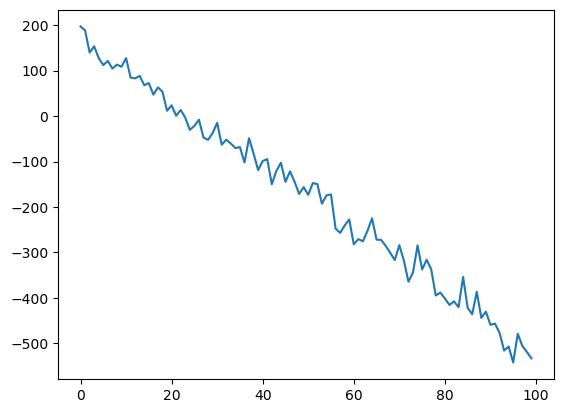

In [17]:
plt.plot(l)

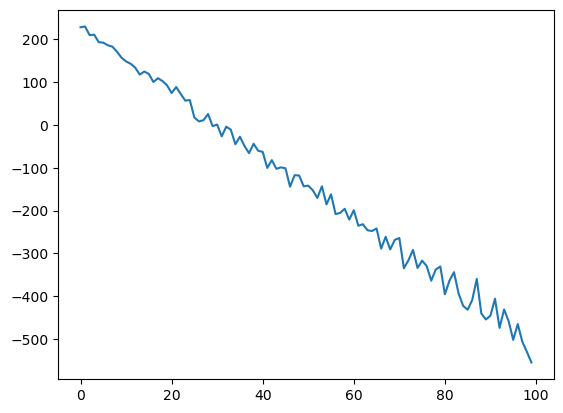

In [3]:
plt.plot(l)

The code you provided is a PyTorch implementation of a Variable Auto-regressive Network (VAN). There are a few potential issues that could be causing the code to not work as expected:

In-place operations on Variables that require grad: In the forward method of the VAN class, you are modifying x[0] in-place. This could potentially cause issues with PyTorch's autograd system. Instead of modifying x in-place, consider creating a new tensor with the modified values.

Potential division by zero in Kulback_Leibler function: If any value in p is zero, torch.log(q/p) will throw an error because division by zero is undefined. You should add a small constant to p to prevent division by zero.

Use of numpy functions on PyTorch tensors: In the train function, you are using np.random.binomial on a PyTorch tensor. This could cause issues because numpy functions do not support PyTorch's autograd system. Consider using PyTorch's random functions instead.

Creating new tensors in a loop: In the train function, you are creating new tensors in a loop. This could potentially cause memory issues. Consider pre-allocating the tensor outside the loop and then filling in the values inside the loop.

Calling .detach() on tensors: In the train function, you are calling .detach() on tensors before using them in computations. This will prevent PyTorch's autograd system from tracking computations on these tensors, which could cause issues with backpropagation.

Printing gradients: In the train function, you are trying to print the gradients of q_theta_predit and y_train. However, these tensors may not have gradients because they are not involved in the computation of loss. Only tensors that are involved in the computation of loss and have requires_grad=True will have gradients.

Please provide more specific details about the error messages you are encountering for a more accurate diagnosis.

In [5]:

for param in mymodel.parameters():
    print(param.grad)

None
None


In [8]:
# exemple d'utilisation de torch.backward()
x = torch.tensor([2.0], requires_grad=True)
z = torch.tensor([1.0], requires_grad=True)
y = x ** 2 + 2 * z + x*z
y.backward()
print(x.grad)
print(z.grad)
# x.grad est égal à 4.0 car y = x^2 et dy/dx = 2x donc dy/dx=4 en x=2



tensor([5.])
tensor([4.])


In [19]:
y_1=torch.tensor([[1.0], [2.0], [3.0], [4.0]], requires_grad=True)
y_2=torch.tensor([[5.0], [2.0], [3.0], [4.0]], requires_grad=True)
loss=loss_fn(y_1, y_2)
loss.backward()
print(loss.grad)

None


C:\Users\grego\AppData\Local\Temp\ipykernel_22400\921216634.py:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:494.)
  print(loss.grad)


In [13]:


def loss_fn(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)

In [22]:
type(torch.tensor(float(np.random.binomial(1, 0.5))))

torch.Tensor

In [13]:
a=torch.tensor([1.0])
print(a)
a.requires_grad=True
b=a*5
print(b)
b.backward()
print(b)
a.grad


tensor([1.])
tensor([5.], grad_fn=<MulBackward0>)
tensor([5.], grad_fn=<MulBackward0>)


tensor([5.])

In [9]:
def KL(q,p):
    return torch.sum(torch.log(q/p))

In [10]:
p=torch.tensor([0.1, 0.2, 0.3, 0.4])
q=torch.tensor([0.25, 0.25, 0.25, 0.25])
print(KL(q,p))
print(Kulback_Leibler(q,p))

tensor(0.4871)
tensor(0.4871)


In [ ]:
# il me faut un loss(y1, y2) pour pouvoir écrire loss(model(x_train), y_train)

In [6]:
x=torch.tensor([1, 2, 3, 4, 5]).float()
modified_x = x.clone()  # Create a copy of x to avoid modifying the original tensor
modified_x[0] = 0.5 
modified_x

tensor([0.5000, 2.0000, 3.0000, 4.0000, 5.0000])

In [4]:
torch.sum(torch.tensor([1, 2, 3, 4, 5]).float())

tensor(15.)

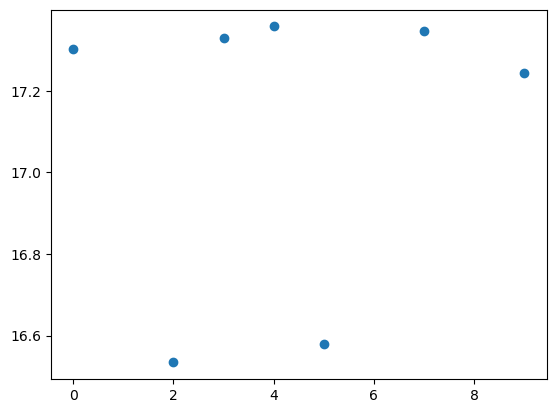

In [4]:
plt.plot(l, 'o')

Epoch [10/100], Loss: 10.4826
Epoch [20/100], Loss: 7.7014
Epoch [30/100], Loss: 4.5211
Epoch [40/100], Loss: 1.8772
Epoch [50/100], Loss: 0.6904
Epoch [60/100], Loss: 0.3596
Epoch [70/100], Loss: 0.2629
Epoch [80/100], Loss: 0.2197
Epoch [90/100], Loss: 0.1920
Epoch [100/100], Loss: 0.1706


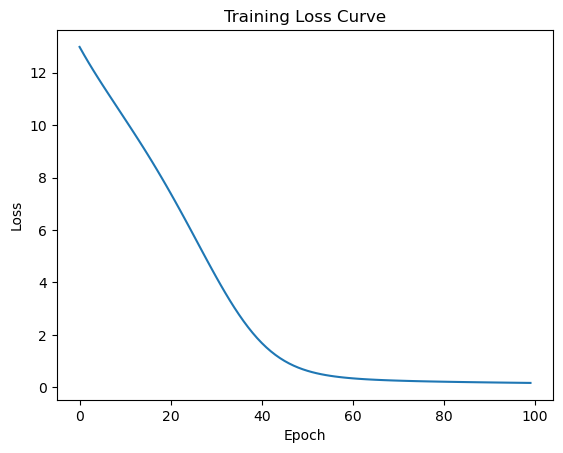

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define a simple multilayer perceptron for regression
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Generate synthetic dataset for regression
def generate_dataset(num_samples=100, input_size=1):
    # Generate random input data
    inputs = torch.randn(num_samples, input_size)
    # Generate target labels as a function of inputs
    targets = 3 * inputs + 2 + 0.2 * torch.randn(num_samples, 1)  # Linear relation with some noise
    return inputs, targets

# Define training function
def train(model, optimizer, criterion, inputs, targets, num_epochs=100):
    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    return losses

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
input_size = 1
hidden_size = 10
output_size = 1
learning_rate = 0.01
num_epochs = 100

# Generate dataset
inputs, targets = generate_dataset()

# Initialize model, optimizer, and loss function
model = MLP(input_size, hidden_size, output_size)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Train the model
losses = train(model, optimizer, criterion, inputs, targets, num_epochs)

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


In [1]:

def train(model, p_obj,  n_iter=100, lr=1e-2, train_size=100):
    losses = []
    # p_obj est la distribution à approximer. 
    # elle prend en input un vecteur de 0 et 1 de taille model.input_size et renvoie la proba de ce vecteur
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    # à cette étape, on a un train set, on peut entraîner le modèle
    for epoch in range(n_iter):
        optimizer.zero_grad() # What is this step? IMPORTANT LINE


        
        # il faut tirer un train_set grâce au modèle pour s'entraîner dessus
        train_set=torch.zeros((train_size, model.input_size))
        for i in range(train_size):
            # pour tirer un x dans x_train, on tire une bernoulli de paramètre 0.5 : c'est s_1
            # comment avoir s_2 ? ON fait passer le vecteur [s_1, 0, 0, 0] dans le réseau de neurones
            # en sortie du réseau de neurones, on a y =[ s1 randomn, p(s2|s1), p(s3|s1), p(s4|s1)...]
            # la deuxième coordonnée de y est p(s2|s1), donc on tire une bernoulli de paramètre p(s2|s1)
            # puis on recommence !
            # on fait ça train_size fois
            train_set[i][0]=torch.bernoulli(torch.tensor(0.5).detach())

            for j in range(1, model.input_size):
                y_pred=model(train_set[i])
                p_j= y_pred[j] # c'est p(s_j|s_{i<j})
                # train_set[i][j] = torch.tensor(float(np.random.binomial(1, p_j.detach().numpy()))) # on tire une bernoulli de paramètre p(s_j|s_{i<j}) pour la j-ème variable
                train_set[i][j] = torch.bernoulli(p_j).item() # on tire une bernoulli de paramètre p(s_j|s_{i<j}) pour la j-ème variable
        y_train=torch.tensor([p_obj(s) for s in train_set], requires_grad=True)
        
        # on a notre train set pour cette époque


        listes_de_probas_conditionelles=model(train_set) # on récupère les probas conditionelles, il faut les multiplier pour avoir les probas tout court

        q_theta_predit=torch.zeros(len(listes_de_probas_conditionelles))
        for j, proba_conditionelle in enumerate( listes_de_probas_conditionelles):
            res=torch.tensor(1.0)
            for i in proba_conditionelle:
                res*=torch.tensor(i, requires_grad=True)
            q_theta_predit[j]=res
        # c'est bon on a les probas, on peut appliquer DKL
        loss = Kulback_Leibler(q_theta_predit, y_train)
        loss.backward()
        
        optimizer.step()
        losses.append(loss.item())
        if epoch % (n_iter/10) == 0:
            print(f'Epoch {epoch}: {loss.item()}')
            for param in model.parameters():
                print(param)
    return losses
# on garde train dans un coin